## Check Libs
Check if Tensoflow and Keras libs are correcly installed.

In [1]:
import tensorflow
import keras

print(f'tensorflow:', tensorflow.__version__)
print(f'keras:', keras.__version__)

tensorflow: 2.1.0
keras: 2.3.1


Using TensorFlow backend.


## Import MNIST dataset
Load the MNIST dataset from keras and prints the shape of training and test set.<br>
TrainX is formed by 60k image with resolution 28x28 pixels, TrainY are 60k labels of each image. Test-set is formed by 10k images.

In [2]:
# Import MNIST dataset
from keras.datasets.mnist import load_data

# Load images in memory
(trainX, trainY), (testX, testY) = load_data()

# Summarize the shape
print('Train', trainX.shape, trainY.shape)
print('Test', testX.shape, testY.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


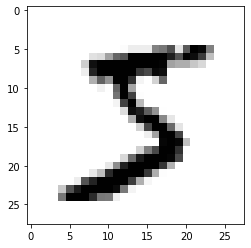

In [3]:
import matplotlib.pyplot as plt

# show white-letter black-background
plt.imshow(trainX[0], cmap='gray')

# show black-letter white-background
plt.imshow(trainX[0], cmap='gray_r')

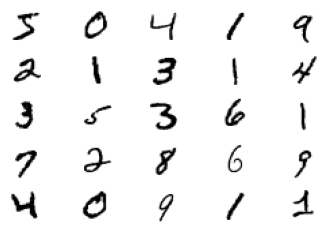

In [4]:
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    
    # turn off axis
    plt.axis('off')
    
    # plot 25 images as 5x5 block
    plt.imshow(trainX[i], cmap='gray_r')
    
plt.show()

The generator model will learn how to generate new plausible handwritten digits between 0-9, using a discriminator that will try to distinguish between real images from the MNIST training dataset and new images output by the generator model.

## Discriminator Model
The discriminator model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake:<br>
- Inputs: image with one channel 28x28 pixels
- Output: binary classification real-fake

The discriminator model has:
- 2 convolutional layers with 64 filters each
- small kernel size of 3x3 pixels
- stride 2x2

The model has no pooling layers and a single node in the output layer with sigmoid activation function to predict whether the input sample is real or fake.<br>
The model is trainde to minimize the binary cross entropy function, apprpriate for binary classification.<br><br>

We use LeakyRelu instead of Relu following some "best-practices", with parameter alpha=0.2.<br>
The dropout layer has a drop-rate od 0.4.<br><br>

After the 2 convolutional layer we use Adam-SGD to optimize with learning-rate of 0.0002 and momentum of 0.5.<br>



In [5]:
from keras.models import Sequential
from keras.optimizers import Adam

from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

from keras.utils.vis_utils import plot_model

In [6]:
def define_discriminator(in_shape=(28, 28, 1)):
    
    # Instantiate a sequential model
    model = Sequential()
    
    # ----- Stack layers -----
    
    # Convlayer-1
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # Convlayer-2
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # Serialize
    model.add(Flatten())
    
    # Add the output layer single neuron
    model.add(Dense(1, activation='sigmoid'))
    
    # ----- End Layers -----
    
    # Define optimizer Adam-SGD
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
    

Show the Discriminator Architecture:<br>
the number of params are obtained by [(w*h*f)+1]*k, where:
- w = filter width
- h = filter height
- f = n° of filters in the previous layer
- k = n° of filters in the current layer

So for the first Cov2D layer we have [(3*3*1)+1]*64 = 640 params.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

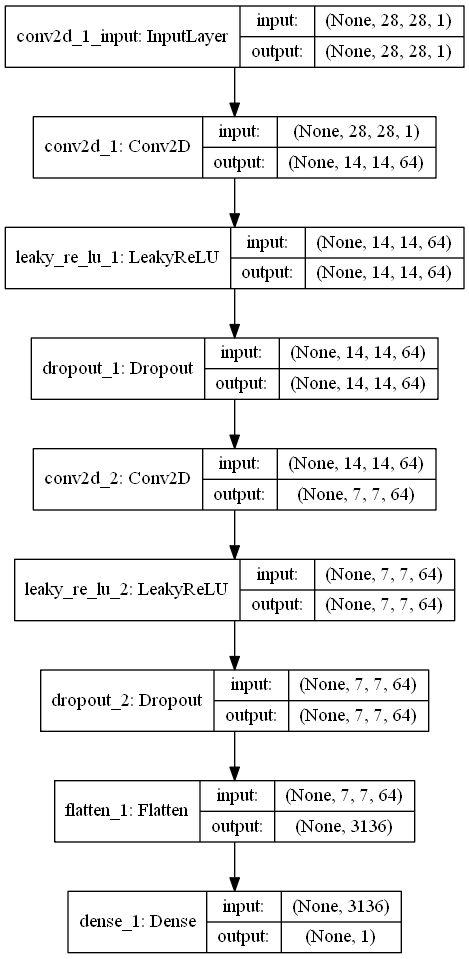

In [7]:
# Instantiate discriminator model
model = define_discriminator()

# Summarize the model
model.summary()

# Plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
import numpy as np

# Load sample function
def load_real_samples():
    
    # Load only the trainX batch
    (trainX, _), (_, _) = load_data()
    
    # Exapand the images from 2D to 3D adding a channel dimension
    X = np.expand_dims(trainX, axis=-1)
    
    # Convert from uint[0, 255] to float and normalized-ranze[0, 1]
    X = X.astype('float32')
    X = X / 255.
    return X

Now we need a function that select a random batch from the real images to feed to the network

In [9]:
def generate_real_samples(dataset, n_samples):
    
    # Choose random instances
    rnd_inst = np.random.randint(0, dataset.shape[0], n_samples)
    
    # Retrieve selected images-batch and generate label(1) that mean they are real
    X = dataset[rnd_inst]
    y = np.ones((n_samples, 1))
    return X, y

And we need also a source of fake images, at moment we just use a random pixel-generation in range [0, 1] and associate them with label 0 for fake.

In [10]:
def generate_fake_samples(n_samples):
    
    # Generate uniform random-numbers in [0,1]
    X = np.random.rand(28 * 28 * n_samples)
    
    # Reshape into a bath of grayscale images
    X = X.reshape((n_samples, 28, 28, 1))
    
    # Generate fake label(0) and return
    y = np.zeros((n_samples, 1))
    return X, y

## Train the Discriminator
This involes repeatedly retrieving samples of real images and samples of generated images and updating the model for a fixed number of iterations. <br>
The train_discriminator() function uses a batch-size of 256 images where 128 are real and 128 are fake.<br>
We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update. This gives insight into how the discriminator model is performing over time.

In [11]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256, verbose=False):
    half_batch = int(n_batch / 2)
    real_acc_list = []
    fake_acc_list = []
    
    # Manually enumerate epochs
    for i in range(n_iter):
        
        # ----- Train on real-img -----
        # Get random real samples
        X_real, Y_real = generate_real_samples(dataset, half_batch)
        # Update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, Y_real)
        real_acc_list.append(real_acc * 100)
        # ----------------------------
        
        # ----- Train on fake-img -----
        X_fake, Y_fake = generate_fake_samples(half_batch)
        # Update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, Y_fake)
        fake_acc_list.append(fake_acc * 100)
        
        # Summarize performance
        if verbose:
            print(f'----- Epoch-{i} -----')
            print(f'Real Accuracy: {real_acc * 100}')
            print(f'Fake Accuracy: {fake_acc * 100}')
    return real_acc_list, fake_acc_list
        

----- Epoch-0 -----
Real Accuracy: 90.625
Fake Accuracy: 7.8125
----- Epoch-1 -----
Real Accuracy: 96.875
Fake Accuracy: 14.84375
----- Epoch-2 -----
Real Accuracy: 96.09375
Fake Accuracy: 44.53125
----- Epoch-3 -----
Real Accuracy: 94.53125
Fake Accuracy: 66.40625
----- Epoch-4 -----
Real Accuracy: 96.875
Fake Accuracy: 82.03125
----- Epoch-5 -----
Real Accuracy: 94.53125
Fake Accuracy: 91.40625
----- Epoch-6 -----
Real Accuracy: 94.53125
Fake Accuracy: 96.09375
----- Epoch-7 -----
Real Accuracy: 95.3125
Fake Accuracy: 98.4375
----- Epoch-8 -----
Real Accuracy: 85.9375
Fake Accuracy: 100.0
----- Epoch-9 -----
Real Accuracy: 89.84375
Fake Accuracy: 100.0
----- Epoch-10 -----
Real Accuracy: 83.59375
Fake Accuracy: 100.0
----- Epoch-11 -----
Real Accuracy: 92.1875
Fake Accuracy: 100.0
----- Epoch-12 -----
Real Accuracy: 88.28125
Fake Accuracy: 100.0
----- Epoch-13 -----
Real Accuracy: 93.75
Fake Accuracy: 100.0
----- Epoch-14 -----
Real Accuracy: 89.0625
Fake Accuracy: 100.0
----- Epoch-

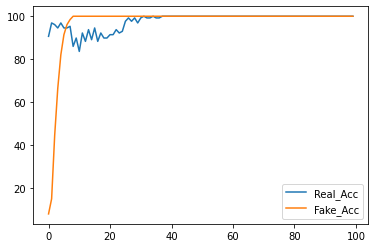

In [12]:
dataset = load_real_samples()
real_acc, fake_acc = train_discriminator(model, dataset, verbose=True)

epoch_ax = np.arange(0, 100)
plt.figure()
plt.plot(epoch_ax, real_acc, label='Real_Acc')
plt.plot(epoch_ax, fake_acc, label='Fake_Acc')
plt.legend()

## Generator Model
The generator model is responsible to create new fake, but plausible, images of handwritten digits.<br>
It does this by taking a point from the latent space as input and outputting a square grayscale image.<br>
The latent space is an arbitrarily defined vector space of Gaussian-values and has no meaning, but by drawing points from this space randomly and providing them to the generator during training, the generator model will assign meaning to the latent points, and in turn, the latent space, until, at the end of training, the latent vector space representst a compressed representation of the output space.<br>
Developing a generator model requires that we transform a vector from the latent space with, 100dim to 2D array with 28x28 or 784 values.<br>
The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size of the output image would be 14x14 or 196 nodes, and a image on quarter the size would be 7x7 or 49 nodes.<br>
We want many parallel versions or interpretations of the input. This is a pattern in convolutional neural network where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input.<br>


In [23]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

def define_generator(latent_dim):
    
    # Initialize the model
    model = Sequential()
    n_nodes = 128 * 7 * 7
    
    # Foundation of 7x7 image
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    
    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # Upsample to 28x28
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
    return model

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 28, 28, 128)      

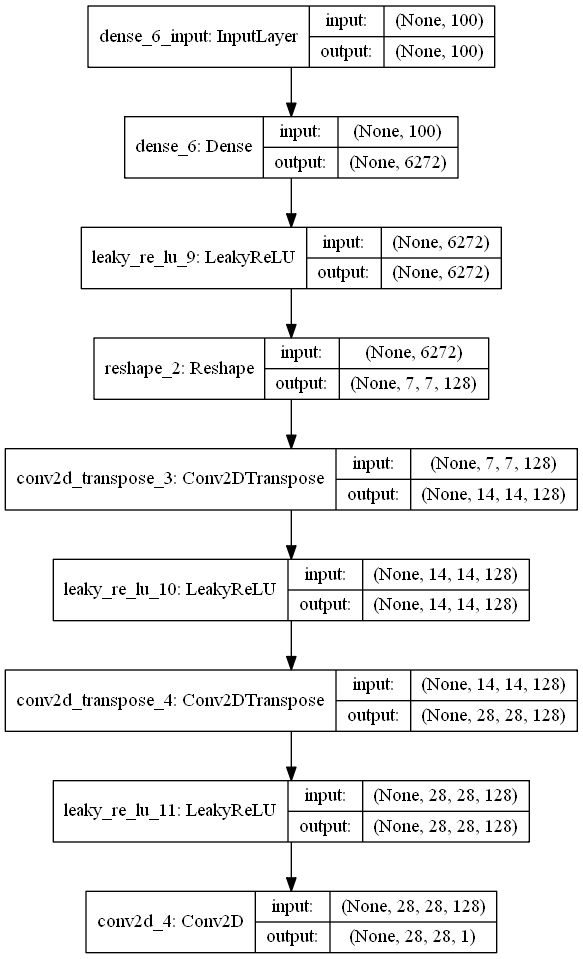

In [24]:
# Define latent dimensions
latent_dim = 100

# Instantiate discriminator model
model_gen = define_generator(latent_dim)

# Summarize the model
model_gen.summary()

# Plot the model
plot_model(model_gen, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Now we define a latent-space point generator

In [32]:
def generate_latent_point(latent_dim, n_samples):
    
    # Random point generation
    x_input = np.random.rand(latent_dim * n_samples)
    
    # Reshape into batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

In [35]:
# Use the latent_point generator to update the fake generator
def generate_fake_samples_up(g_model, latent_dim, n_samples):
    
    x_input = generate_latent_point(latent_dim, n_samples)
     
    # Predict output
    X = g_model.predict(x_input)
    
    # Create fake label
    y = np.zeros((n_samples, 1))
    return X, y

Now we can test our generator model

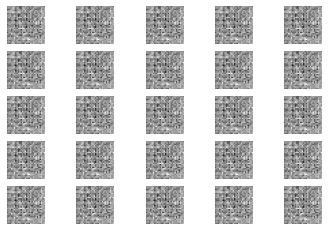

In [39]:
# Generate samples and latent-space dim
n_samples = 25
latent_dim = 100

gen_model = define_generator(latent_dim)

X, _ = generate_fake_samples_up(gen_model, latent_dim, n_samples)

# Plot generated images
for i in range(n_samples):
    
    # define subplot
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    
    plt.imshow(X[1, :, :, 0], cmap='gray_r')

plt.show()

## Train the Generator Model
The weights in the generator model are updated based on the performance of the discriminator model.<br>
When the discriminator is good at detecting fake samples, the generator is updated mode, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.<br>
There may be manyu ways to implement this using Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models: its not a new third model, but just a new logical model that uses the already-defined layers and weights.<br>
When training the generator in this logical GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore,  when the generator is trained as part of the GAN, we will mark the generated samples as real.<br>
The define_gan() function takes as input the already defined discriminator and generator models and creates the new logical model merging them.<br>
The GAN model uses the same binary cross entropy loss function as the discriminator and the efficient Adam-SGD with the same parameters as before.<br>

In [42]:
def define_gan(g_model, d_model):
    
    # Make model in the discriminator not trainable
    d_model.trainable = False
    
    # Connect the models
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    
    # Compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_19 (Sequential)   (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


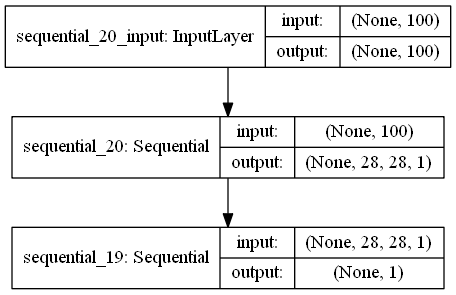

In [43]:

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

gan_model.summary()

plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Training the composite model involves generating a batch worth of points in the latentspace via generate_latent_point() function

In [71]:
def train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        print(f'\n---------------------')
        print(f'----- Epoch-{i} -----')
        for j in range(bat_per_epo):
            
            # Random select real samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            
            # Generate fake samples
            X_fake, y_fake = generate_fake_samples_up(g_model, latent_dim, half_batch)
            
            # Create trainingset for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            
            # Update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            
            # Prepare points in latent-space
            X_gan = generate_latent_point(latent_dim, n_batch)

            # Create inverted labels for fake samples
            y_gan = np.ones((n_batch, 1))
            
            # Update the generator via discriminator error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            '''
            print(f'----- Batch-{j} -----')
            print(f'd_loss: {d_loss}')
            print(f'g_loss: {g_loss}')
            '''
            
        if (i + 1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            

## GAN performance evaluation
There is no objective ways to evaluate the performance of a GAN model, we can handle the sintuantion only by:
- Periodically evaluate the classification accuracy of the discriminator on real and fake images.
- Periodically generate many images and save them to file for subjective review
- Periodically save the generator model
All the 3 actions can be performed at same time. Training the GAN over many epochs, such as hundreds or thousands, will result in many snapshots of the model that can be inspected and from which specific outputs and models can be cherry picked for later use.<br>


In [72]:
def save_plot(examples, epoch, n=10):
    
    # Plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[1, :, :, 0], cmap='gray_r')

    # Save the plot to file
    filename = f'generated_plot/generated_plot_e{epoch + 1}.png'
    plt.savefig(filename)
    plt.close()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    
    # Prepare real samples and evaluate the discriminator
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    
    # Prepare fake samples and evaluate the generator
    X_fake, y_fake = generate_fake_samples_up(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    
    '''
    print('------------------------------------------------------------------------------------------------------------')
    print(f'Real Accuracy: {real_acc * 100}')
    
    print('\n------------------------------------------------------------------------------------------------------------')
    print(f'Fake Accuracy: {fake_acc * 100}')
    '''
    
    # Save plot
    save_plot(X_fake, epoch)
    
    # Save generator
    filename = f'generator/generator_model_{epoch + 1}.h5'
    g_model.save(filename)

In [73]:
train_gan(g_model, d_model, gan_model, dataset, latent_dim)


---------------------
----- Epoch-0 -----

---------------------
----- Epoch-1 -----

---------------------
----- Epoch-2 -----

---------------------
----- Epoch-3 -----

---------------------
----- Epoch-4 -----

---------------------
----- Epoch-5 -----

---------------------
----- Epoch-6 -----

---------------------
----- Epoch-7 -----

---------------------
----- Epoch-8 -----

---------------------
----- Epoch-9 -----

---------------------
----- Epoch-10 -----

---------------------
----- Epoch-11 -----

---------------------
----- Epoch-12 -----

---------------------
----- Epoch-13 -----

---------------------
----- Epoch-14 -----

---------------------
----- Epoch-15 -----

---------------------
----- Epoch-16 -----

---------------------
----- Epoch-17 -----

---------------------
----- Epoch-18 -----

---------------------
----- Epoch-19 -----

---------------------
----- Epoch-20 -----


KeyboardInterrupt: 